In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

folder_path = "../../../../../../../Volumes/T7 Shield/exp_1/"
output_path = "../../../../../../../Volumes/T7 Shield/reduced"
file_prefix = "ORCA025.L46.LIM2vp.CFCSF6.MOPS.JRA.LP04-KLP002.hind_2009_df.pkl"


# Load the original pickle file
input_file = folder_path + file_prefix
df = pd.read_pickle(input_file)
df = df[df['time_centered'] == '2009-01-16 12:00:00']

# df = df[df['tmask'] == 1]
# df['co2_flux'].describe()


FileNotFoundError: [Errno 2] No such file or directory: '../../../../../../../Volumes/T7 Shield/exp_1/ORCA025.L46.LIM2vp.CFCSF6.MOPS.JRA.LP04-KLP002.hind_2009_df.pkl'

In [ ]:
df['co2flux'].describe()

count    1.084997e+07
mean     4.018340e-01
std      1.378618e+00
min     -3.946775e+01
25%     -2.897619e-01
50%      7.823434e-02
75%      1.137237e+00
max      1.814287e+01
Name: co2flux, dtype: float64

/opt/homebrew/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


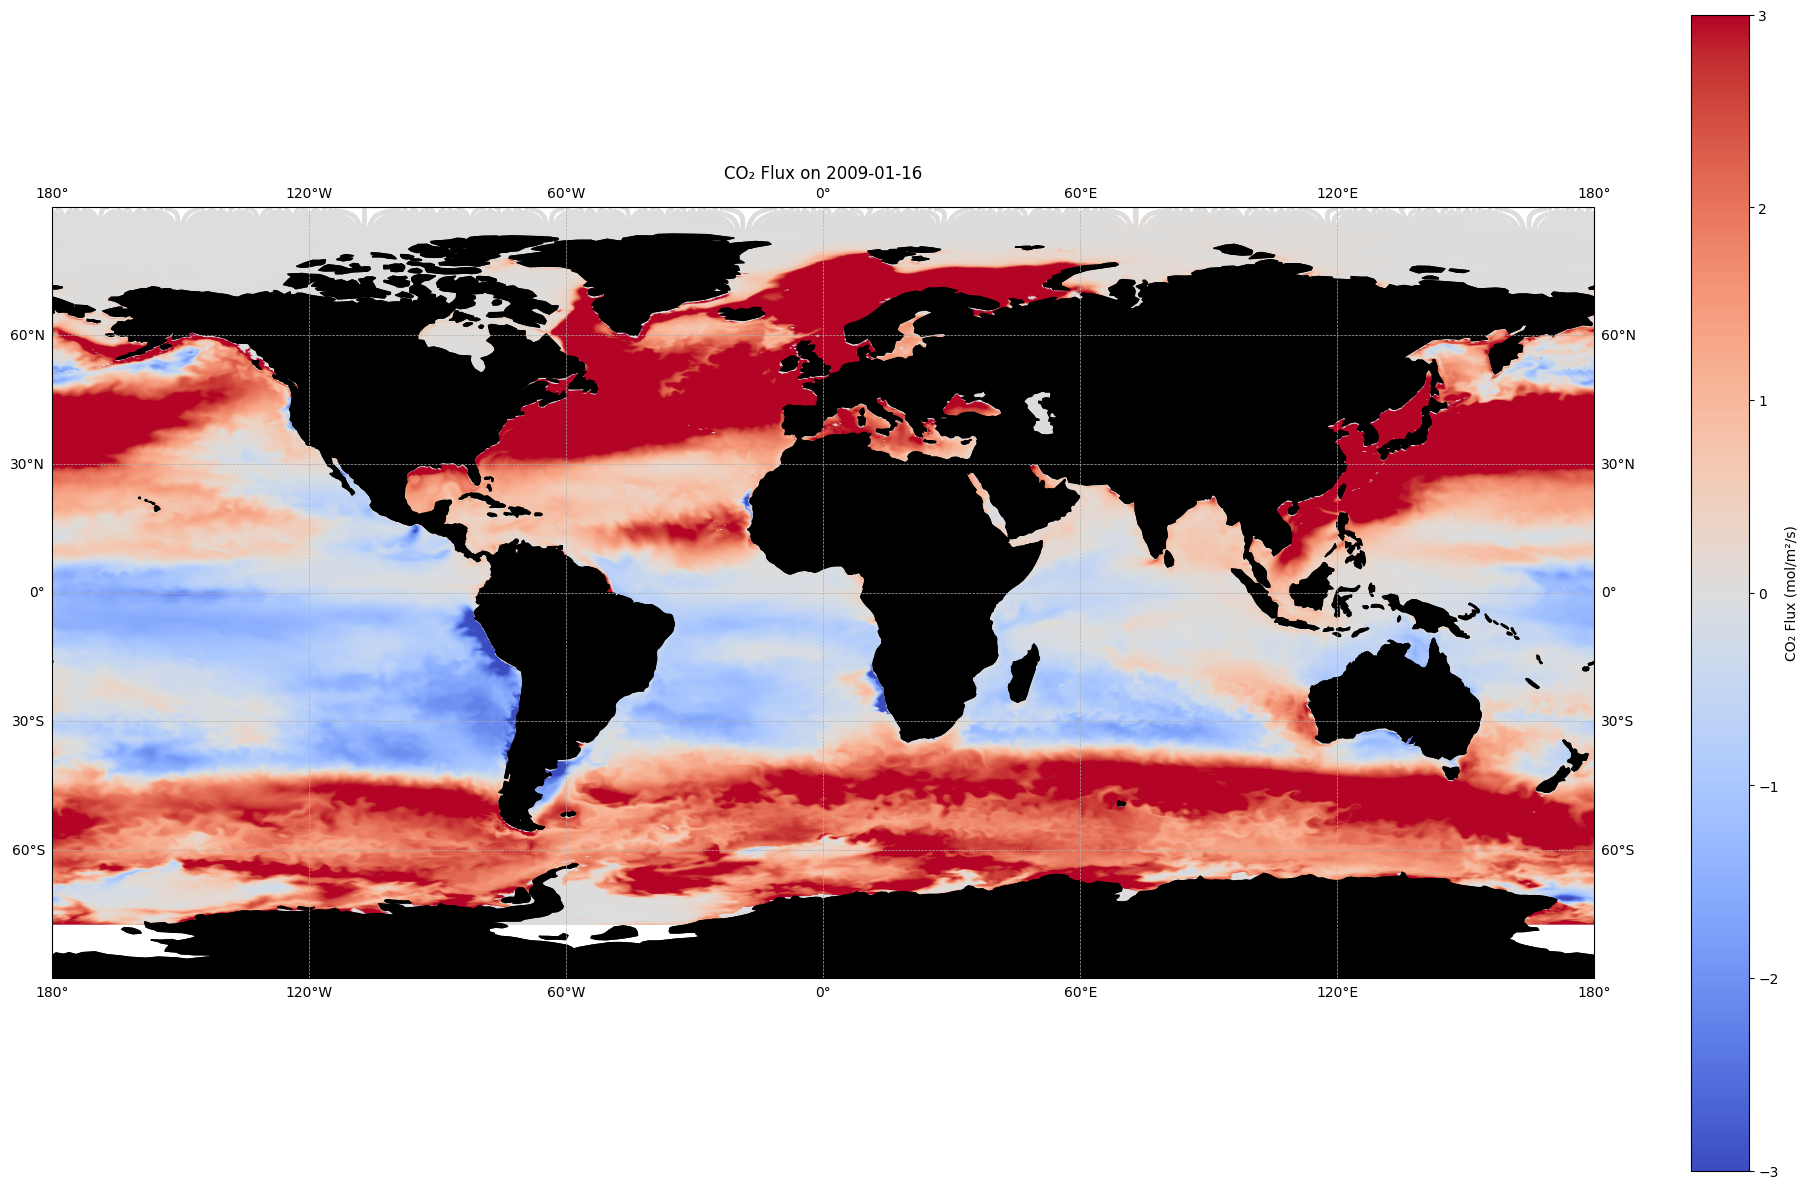

In [ ]:
latitudes = np.linspace(-77, 90, 1020)
longitudes = np.linspace(-180, 180, 1440)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Interpolate temperature data onto the grid
from scipy.interpolate import griddata

temperature_grid = griddata(
    points=(df['nav_lon'].values, df['nav_lat'].values),
    values=df['SST'].values,
    xi=(lon_grid, lat_grid),
    method='linear'
)

# Set up the map
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

# Set land color to black
land = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                     edgecolor='face',
                                     facecolor='black')
ax.add_feature(land)

# Plot the scatter points
sc = ax.scatter(df['nav_lon'], df['nav_lat'], c=df['co2flux'],
                cmap='coolwarm', s=10, edgecolor='none', vmin=-3, vmax=3,
                transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='CO₂ Flux (mol/m²/s)')

# Title and show
plt.title('CO₂ Flux on 2009-01-16')
plt.tight_layout()
plt.show()

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directory where your pickle files are stored
data_dir = '../../../../../../../Volumes/T7 Shield/exp_3'

# Define the specific filenames you want to load
years = range(1958, 1960)  # inclusive range from 1958 to 1958
dataframes = []

for year in years:
    filename = f"{year}.pkl"
    file_path = os.path.join(data_dir, filename)

    if os.path.exists(file_path):
        try:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                if isinstance(df, pd.DataFrame):
                    dataframes.append(df)
                    print(f"Loaded {filename} with shape {df.shape}")
                else:
                    print(f"{filename} is not a DataFrame.")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Combine all loaded DataFrames
if dataframes:
    full_data = pd.concat(dataframes, ignore_index=True)

# Drop all rows where tmask == 0
if 'tmask' in full_data.columns:
    full_data = full_data[full_data['tmask'] != 0]

# Convert datetime columns if needed
if 'time_counter' in full_data.columns:
    full_data['time'] = pd.to_datetime(full_data['time_counter'])
elif 'time_centered' in full_data.columns:
    full_data['time'] = pd.to_datetime(full_data['time_centered'])

# Add month and year for analysis
full_data['month'] = full_data['time'].dt.month
full_data['year'] = full_data['time'].dt.year

# Show available features
print("Available features:", full_data.columns.tolist())

# Exclude coordinates, time, and unneeded fields from analysis
exclude_cols = ['x', 'y', 'time', 'time_counter', 'time_centered', 'e1t', 'e2t', 'tmask']
numeric_features = full_data.select_dtypes(include=[np.number]).columns
numeric_features = [col for col in numeric_features if col not in exclude_cols]

# Create output directory
output_dir = os.path.join(data_dir, "analysis_plots")
os.makedirs(output_dir, exist_ok=True)

# Correlation matrix heatmap
corr_matrix = full_data[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
plt.close()

# Distribution plots
for col in numeric_features:
    plt.figure()
    sns.histplot(full_data[col].dropna(), kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"distribution_{col}.png"))
    plt.close()

# Seasonal (monthly) pattern analysis
monthly_means = full_data.groupby("month")[numeric_features].mean()
for col in numeric_features:
    plt.figure()
    plt.plot(monthly_means.index, monthly_means[col], marker='o')
    plt.title(f"Seasonal Pattern of {col}")
    plt.xlabel("Month")
    plt.ylabel(f"Average {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"seasonal_{col}.png"))
    plt.close()

# Trend (yearly) pattern analysis
yearly_means = full_data.groupby("year")[numeric_features].mean()
for col in numeric_features:
    plt.figure()
    plt.plot(yearly_means.index, yearly_means[col], marker='o')
    plt.title(f"Trend of {col} Over Years")
    plt.xlabel("Year")
    plt.ylabel(f"Average {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"trend_{col}.png"))
    plt.close()


Loaded 1958.pkl with shape (17667384, 23)
Loaded 1959.pkl with shape (17667384, 23)
Loaded 2 files. Final shape: (35334768, 23)
Available features: ['y', 'x', 'time_counter', 'nav_lat', 'nav_lon', 'time_centered', 'SST', 'tmask', 'e1t', 'e2t', 'SAL', 'ice_frac', 'mixed_layer_depth', 'heat_flux_down', 'water_flux_up', 'stress_X', 'stress_Y', 'currents_X', 'currents_Y', 'fco2_pre', 'fco2', 'co2flux_pre', 'co2flux', 'time', 'month', 'year']


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data_dir = '../../../../../../../Volumes/T7 Shield/preprocessed_new_exp1_full'

data_dir = '../../data/preprocessed_new_1_degree'
output_dir = '../plots/general/analysis'

feature_names = ['SST', 'SAL', 'ice_frac', 'mixed_layer_depth', 'heat_flux_down', 'water_flux_up',
                 'stress_X', 'stress_Y', 'currents_X', 'currents_Y', 'month', 'tmask',
                 'year', 'nav_lat', 'nav_lon', 'global_co2']
target_names = ['fco2', 'fco2_pre', 'co2flux', 'co2flux_pre']

all_data = []

# === Load and merge feature + target data ===
for i in range(1, 49):  # Months 1 to 732
    try:
        X_feat = np.load(os.path.join(data_dir, f"{i}_features.npy"))  # shape (H, W, 16)
        X_targ = np.load(os.path.join(data_dir, f"{i}_targets.npy"))   # shape (H, W, 4)

        H, W, _ = X_feat.shape
        feat_flat = X_feat.reshape(-1, len(feature_names))
        targ_flat = X_targ.reshape(-1, len(target_names))

        df = pd.DataFrame(feat_flat, columns=feature_names)
        df[["fco2", "fco2_pre", "co2flux", "co2flux_pre"]] = targ_flat
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

        # Drop rows where tmask == 0
        df = df[df["tmask"] != 0]

        all_data.append(df)
        print(f"Loaded and merged month {i} → {df.shape[0]} rows")

    except Exception as e:
        print(f"Skipped month {i}: {e}")

# === Concatenate all months into a single DataFrame ===
if not all_data:
    raise RuntimeError("No data loaded.")
full_data = pd.concat(all_data, ignore_index=True)

# === Prepare for analysis ===
numeric_features = [col for col in feature_names + target_names + ['month_sin','month_cos']
                    if col not in ['tmask']]

Loaded and merged month 1 → 37638 rows
Loaded and merged month 2 → 37638 rows
Loaded and merged month 3 → 37638 rows
Loaded and merged month 4 → 37638 rows
Loaded and merged month 5 → 37638 rows
Loaded and merged month 6 → 37638 rows
Loaded and merged month 7 → 37638 rows
Loaded and merged month 8 → 37638 rows
Loaded and merged month 9 → 37638 rows
Loaded and merged month 10 → 37638 rows
Loaded and merged month 11 → 37638 rows
Loaded and merged month 12 → 37638 rows
Loaded and merged month 13 → 37638 rows
Loaded and merged month 14 → 37638 rows
Loaded and merged month 15 → 37638 rows
Loaded and merged month 16 → 37638 rows
Loaded and merged month 17 → 37638 rows
Loaded and merged month 18 → 37638 rows
Loaded and merged month 19 → 37638 rows
Loaded and merged month 20 → 37638 rows
Loaded and merged month 21 → 37638 rows
Loaded and merged month 22 → 37638 rows
Loaded and merged month 23 → 37638 rows
Loaded and merged month 24 → 37638 rows
Loaded and merged month 25 → 37638 rows
Loaded an

In [5]:
statistic_features = [col for col in feature_names + target_names
                    if col not in ['tmask','nav_lat','nav_lon','year','month']]

# === Compute statistics for numeric features and targets ===
stats = full_data[statistic_features].agg(['min', 'max', 'mean','std']).transpose()
stats.columns = ['min', 'max', 'mean','std']
stats = stats.round(4)  # Round to 4 decimal places

# === Display the statistics ===
print(stats)

                         min        max      mean      std
SST                  -2.0335    34.9773   16.0144  11.0214
SAL                   0.0017    42.9179   34.4791   2.0742
ice_frac              0.0000     1.0000    0.0751   0.2408
mixed_layer_depth    12.8391  2856.0601   54.1104  61.8420
heat_flux_down    -1241.6901   274.2207   -2.2594  92.3109
water_flux_up        -0.0297     0.0143   -0.0000   0.0002
stress_X             -0.6913     0.5742    0.0160   0.0796
stress_Y             -0.5760     0.5498   -0.0003   0.0423
currents_X           -1.5097     1.6885    0.0119   0.1238
currents_Y           -1.6285     2.2356    0.0015   0.0763
global_co2          386.9500   406.3100  396.3500   6.1602
fco2                 23.9545  1121.9783  378.1453  33.8604
fco2_pre             23.9545   913.5407  280.9859  30.5922
co2flux             -47.6922    27.1420    0.7438   1.7226
co2flux_pre         -40.5061    20.1132    0.1376   1.4283


In [10]:
# === Correlation Matrix ===
corr_matrix = full_data[numeric_features].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "correlation_matrix.png"))
plt.close()

# === Distribution Plots ===
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(full_data[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"distribution_{col}.png"))
    plt.close()

# === Seasonal (Monthly) Patterns ===
monthly_means = full_data.groupby("month")[numeric_features].mean()
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    plt.plot(monthly_means.index, monthly_means[col], marker='o')
    plt.title(f"Seasonal Pattern of {col}")
    plt.xlabel("Month")
    plt.ylabel(f"Average {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"seasonal_{col}.png"))
    plt.close()

# === Yearly Trend ===
yearly_means = full_data.groupby("year")[numeric_features].mean()
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    plt.plot(yearly_means.index, yearly_means[col], marker='o')
    plt.title(f"Trend of {col} Over Years")
    plt.xlabel("Year")
    plt.ylabel(f"Average {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"trend_{col}.png"))
    plt.close()